$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Ridge Regression with K-Fold Cross-Validation

*Yinzhi Deng*

## Overview

<font color="red">This text box has been changed, on February 6th! </font>

Start with your `train`, `use` and `rmse` functions from Assignment 1.  Add the `partitionKFolds` function from lecture.  Write a new function named `multipleLambdas(X,T,nFolds,lambdas):` that

* Initialize `foldCount` to 0.
* Initialize `results` to empty list.
* For each `Xtrain,Ttrain,Xval,Tval,Xtest,Ttest` partition returned by `partitionKFolds` with `shuffle=True`:
  * For each value of $\lambda$ in `lambdas`:
    * `train` a linear model of `Xtrain,Ttrain` using ridge regression with $\lambda$.
    * `use` the model on `Xtrain`, `Xval`, and `Xtest` and calculate the `rmse` for each.
    * Append to a `results` list the value of `foldCount`, $\lambda$, and the three above `rmse`'s.
  * Increment `foldCount` by 1.
* Convert list of lists `results` into a `numpy` array.
* Initialize `bestResults` to empty list.
* For each value of `range(foldCount)`, select rows of `results` for that fold index, find row with lowest validation error, add that row to a list of `bestResults`.
* Return `bestResults` made into a numpy array.

This returns a numpy array containing one row for each fold, and containing the fold index, the best value of $\lambda$ for that fold, and the three errors, training, validation and testing set errors.

## Method

First, we need to add an input `Lambda` to the function `train()`. Then, use the function `partitionKFolds` given by the lecture to establish my own function `multipleLambdas`. Also, this function can select the rows that contain the lowest validation error because of the different Lambdas, and collect all these rows to create the bestResults matrix.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%precision 4

'%.4f'

In [4]:
def train(X,T,lamb):
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    d = X.shape[1]
    X = np.divide((X-means),stds)
    X = np.hstack((np.ones((X.shape[0],1)),X))
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( X.T @ X + lambDiag, X.T @ T)
    #w = np.linalg.lstsq(np.dot(X.T,X),np.dot(X.T,T))
    w = w[0]
    return {'means':means,'stds':stds,'w':w,'X':X,'lamb':lambDiag}

In [5]:
def use(X,model):
    means = model['means']
    stds = model['stds']
    X = np.divide((X-means),stds)
    X = np.hstack((np.ones((X.shape[0],1)),X))
    w = model['w']
    predict = np.dot(X, w)
    return predict

In [6]:
def rmse(predict,T):
    error = np.sqrt(np.mean((predict - T) ** 2))
    return error

In [7]:
def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [8]:
def multipleLambdas(X, T, nFolds, lambdas=[0]):
    foldCount = 0
    results = []
    bestResults = []
    lambdas = np.array(lambdas)
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            #print(lamb)
            #print(Xtrain.shape)
            predict = use(Xval,model)
            results.append([foldCount,
                            lamb,
                            rmse(use(Xtrain,model),Ttrain),
                            rmse(use(Xval,model),Tval),
                            rmse(use(Xtest,model),Ttest)])
        foldCount = foldCount + 1
    results = np.array(results)
    #print(foldCount)
    #print(results)
    fc = np.arange(foldCount) #this is used to create a list that its size is foldCount as the times of loop
    for n in fc:
        chosenResults = results[results[:,0]==n,:]
        minErrorNum = np.argmin(chosenResults[:,3])
        bestResults.append(results[n*lambdas.shape[0]+minErrorNum,:].tolist())
        #'n*lambdas.shape[0]' means the index of the rows with the lowest validation need to add the rows with same lambdas
    bestResults = np.array(bestResults)
    #print(results.shape)
    return bestResults

The function `get_avgresults` is used to find the average train errors, validation errors, and test errors depending on the increasing Lambdas, so that we can know the tendency of the errors' changes when the Lambdas increase.

In [9]:
def get_avgresults(X, T, nFolds, lambdas=[0]):
    results = []
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            predict = use(Xval,model)
            results.append([lamb,
                            rmse(use(Xtrain,model),Ttrain),
                            rmse(use(Xval,model),Tval),
                            rmse(use(Xtest,model),Ttest)])
    results = np.array(results)
    avgresults = []
    for lam in lambdas:
        avgresults.append( [lam] + np.mean(results[results[:,0]==lam,1:],axis=0).tolist())
    avgresults = np.array(avgresults)
    return avgresults

## Data

The data I use is called Boston Housing Data. It was found from http://archive.ics.uci.edu/ml/datasets/Housing and this dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. And here are the meanings of each attribute below:

1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per 10,000
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in $1000's

In [10]:
data = np.loadtxt('housing.data')

In [11]:
names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

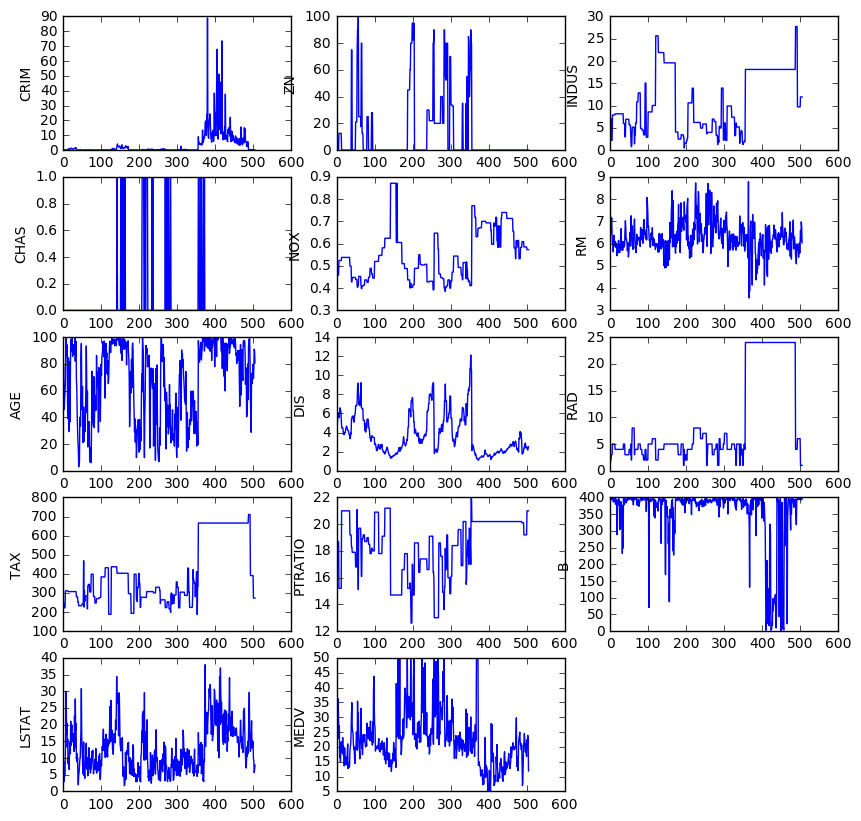

In [12]:
plt.figure(figsize=(10,10))
nrow,ncol = data.shape
for c in range(ncol):
    plt.subplot(5,3, c+1)
    plt.plot(data[:,c])
    plt.ylabel(names[c])

From the plots listed above, I notice that the MEDV, the 'Median value of owner-occupied homes in $1000's' maybe the target data I want to predict by building a linear regression model from other data, because as we know, the price of a house depends on all of the attributes of this house. Thus, I want to try to predict MEDV from the other attributes. I found that the column of MEDV is the last one, so it is time to select it and make it as a one column matrix.

In [13]:
T = data[:,13:]
T.shape

(506, 1)

In [14]:
X = data[:,0:13]
X.shape

(506, 13)

In [15]:
Xnames = names[0:13]
Tname = names[13]
Xnames,Tname

(['CRIM',
  'ZN',
  'INDUS',
  'CHAS',
  'NOX',
  'RM',
  'AGE',
  'DIS',
  'RAD',
  'TAX',
  'PTRATIO',
  'B',
  'LSTAT'],
 'MEDV')

## Results

Now, I apply my functions to the data. 

In [16]:
results = multipleLambdas(X, T, 5, range(0,10))
results

array([[  0.    ,   9.    ,   5.0854,   4.9596,   3.5611],
       [  1.    ,   9.    ,   4.8594,   6.1675,   3.8271],
       [  2.    ,   9.    ,   3.8067,   8.7962,   3.0152],
       [  3.    ,   9.    ,   5.2111,   5.0367,   3.2385],
       [  4.    ,   9.    ,   5.0854,   3.5611,   4.9596],
       [  5.    ,   9.    ,   4.3071,   7.7414,   6.541 ],
       [  6.    ,   9.    ,   3.4969,   8.7467,   4.4632],
       [  7.    ,   9.    ,   4.8206,  10.4463,   5.6039],
       [  8.    ,   9.    ,   4.8594,   3.8271,   6.1675],
       [  9.    ,   9.    ,   4.3071,   6.541 ,   7.7414],
       [ 10.    ,   9.    ,   3.6106,   8.1305,   3.9772],
       [ 11.    ,   9.    ,   4.8679,   4.2464,   5.196 ],
       [ 12.    ,   9.    ,   3.8067,   3.0152,   8.7962],
       [ 13.    ,   9.    ,   3.4969,   4.4632,   8.7467],
       [ 14.    ,   0.    ,   3.5983,   3.8902,   8.1608],
       [ 15.    ,   9.    ,   3.1405,  16.3626,  16.5421],
       [ 16.    ,   9.    ,   5.2111,   3.2385,   5.0367

In [17]:
results_of_newLambda = multipleLambdas(X, T, 5, range(0,30))
results_of_newLambda

array([[  0.    ,  29.    ,   5.1831,   4.814 ,   3.304 ],
       [  1.    ,  20.    ,   4.9158,   6.1405,   3.6465],
       [  2.    ,  29.    ,   3.8931,   8.5634,   2.9899],
       [  3.    ,  29.    ,   5.2917,   4.7578,   3.0813],
       [  4.    ,  29.    ,   5.1831,   3.304 ,   4.814 ],
       [  5.    ,  10.    ,   4.3115,   7.7413,   6.5154],
       [  6.    ,  29.    ,   3.5631,   8.4775,   4.3669],
       [  7.    ,  29.    ,   4.9016,   9.6504,   5.5732],
       [  8.    ,  29.    ,   4.9654,   3.559 ,   6.1499],
       [  9.    ,  29.    ,   4.4082,   6.3029,   7.7847],
       [ 10.    ,  29.    ,   3.6629,   8.0611,   4.2346],
       [ 11.    ,  29.    ,   4.9446,   4.0974,   5.2739],
       [ 12.    ,  20.    ,   3.8514,   2.9732,   8.6484],
       [ 13.    ,  28.    ,   3.5595,   4.3667,   8.4872],
       [ 14.    ,   0.    ,   3.5983,   3.8902,   8.1608],
       [ 15.    ,  29.    ,   3.2153,  12.1287,  13.4605],
       [ 16.    ,  29.    ,   5.2917,   3.0813,   4.7578

<font color="red">As the `results` matrix I acquire, I notice that as the `nFold` is 5, the rows with the lowest validation errors are mostly happen when the Lambdas are 9. And the interesting things are when I change the lambdas range from `range(0,10)` to `range(0,30)`, I found most of the rows with the lowest validation errors are gotten when their lambdas are 29, which gives me a prediction that the best results tend to happen when their lambdas are the biggest of their ranges.</font>

Then, due to the best results, I set the Lambda to 9, and see what will happen to the linear regression plotting.

In [18]:
model = train(X, T, 9)
predict = use(X, model)
error = rmse(predict, T)
error

4.6857

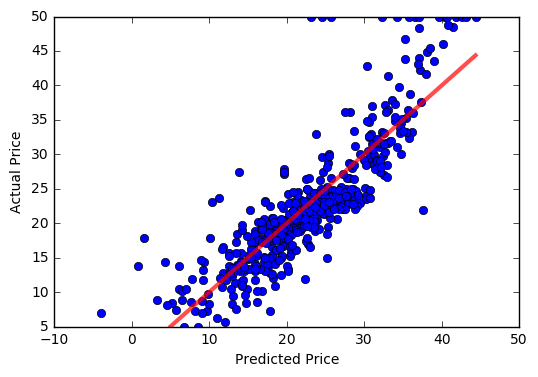

In [19]:
plt.plot(predict,T,'o')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
# add a 45 degree line
a = max(min(predict),min(T))
b = min(max(predict),max(T))
plt.plot([a,b],[a,b], 'r', linewidth=3,alpha=0.7);

In [21]:
avgresults = get_avgresults(X, T, 5, range(0,10))
avgresults

array([[ 0.    ,  4.3014,  7.2752,  7.2752],
       [ 1.    ,  4.3018,  7.2123,  7.2123],
       [ 2.    ,  4.3028,  7.1535,  7.1535],
       [ 3.    ,  4.3043,  7.0986,  7.0986],
       [ 4.    ,  4.3063,  7.047 ,  7.047 ],
       [ 5.    ,  4.3086,  6.9985,  6.9985],
       [ 6.    ,  4.3113,  6.9528,  6.9528],
       [ 7.    ,  4.3142,  6.9096,  6.9096],
       [ 8.    ,  4.3173,  6.8687,  6.8687],
       [ 9.    ,  4.3206,  6.83  ,  6.83  ]])

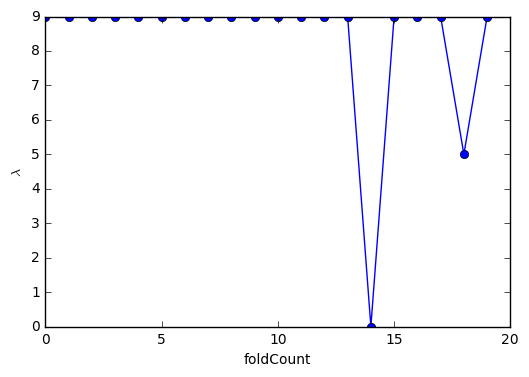

In [22]:
plt.plot(results[:,0],results[:,1],'o-')
plt.xlabel('foldCount')
plt.ylabel('$\lambda$')

The plot above shows that at the `range(0,10)`, the best results happen mostly when they are 9. This may shows the best lambdas creating the best results tend to be the largest among the ranges.

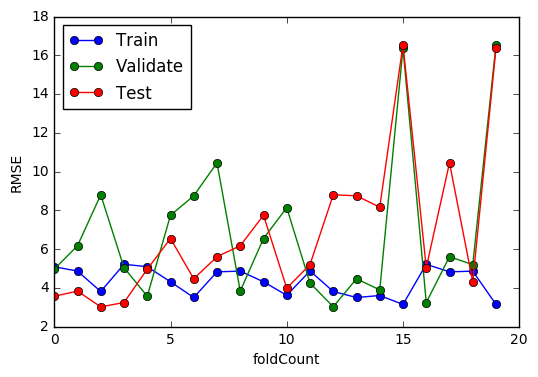

In [23]:
plt.plot(results[:,0],results[:,2:],'o-')
plt.xlabel('foldCount')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

The plot above shows the variation trend of three `RMSE` when the `foldCount` changes. As this plot, I cannot see any tendency of the changes.

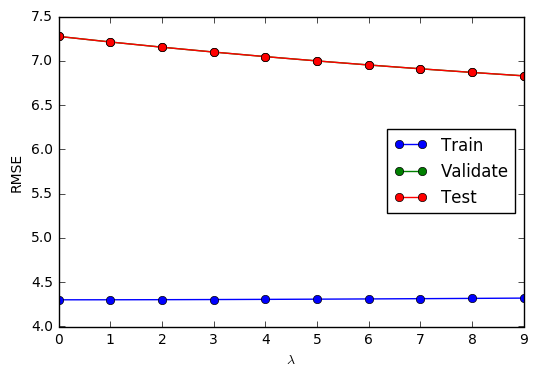

In [24]:
plt.plot(avgresults[:,0],avgresults[:,1:],'o-')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

The plot above shows the variation trend of the means of three RMSE with the change of Lambda. As it shown, i Found that the average validation errors and the average test errors are totally the same. The reason I think is because they use all of the folds when they are traversing with the different folds distributions. And they are dereasing when lambdas are increased, which also prove the prediction I made above, which is the best results tend to appear when the lamdas are the largest among their ranges.

Then I tried to find the weights of the inputs when the lambdas increases. And the function `get_weight` shown below can achieve this requirement.

In [25]:
def get_weight(X, T, nFolds, lambdas=[0]):
    weight_results = []
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            #predict = use(Xval,model)
            print(lamb)
            print(model['w'][:,0])
            #weight_results.append(
                            #model['w'][:,0])
    #weight_results = np.array(weight_results)
    return 0 #weight_results

In [26]:
# use get_weight(X, T, 5, range(0,10)) to observe the weights.

After observing the results, it is obvious that they are similar to the one obtained from the original data X and T, so I return to use the original ones to show the weights.

In [27]:
model = train(X, T, 9)

In [28]:
w = model['w']
Xnames.insert(13, 'bias')
for wi,name in zip(w.flat,Xnames):
    print('{:8.3f}  {:s}'.format(wi,name))

  22.533  CRIM
  -0.865  ZN
   0.966  INDUS
  -0.027  CHAS
   0.706  NOX
  -1.834  RM
   2.737  AGE
  -0.028  DIS
  -2.880  RAD
   2.143  TAX
  -1.604  PTRATIO
  -1.994  B
   0.845  LSTAT
  -3.635  bias


After comparing them, I decide to delete the columns of inputs of CHAS and DIS to establish a new input matrix. Then I do the same process to see if there are any differences.

In [29]:
X1 = np.delete(X,3,1)
X2 = np.delete(X,7,1)
new_results = multipleLambdas(X2, T, 5, range(0,10))
new_results

array([[  0.    ,   9.    ,   5.4293,   5.2139,   3.4917],
       [  1.    ,   9.    ,   5.1003,   6.8151,   4.0492],
       [  2.    ,   9.    ,   4.075 ,   9.2029,   3.3791],
       [  3.    ,   9.    ,   5.4914,   5.3705,   3.2098],
       [  4.    ,   9.    ,   5.4293,   3.4917,   5.2139],
       [  5.    ,   9.    ,   4.4758,   8.436 ,   6.8127],
       [  6.    ,   9.    ,   3.7487,   8.9924,   4.4628],
       [  7.    ,   9.    ,   5.0177,  11.2168,   6.1803],
       [  8.    ,   9.    ,   5.1003,   4.0492,   6.8151],
       [  9.    ,   9.    ,   4.4758,   6.8127,   8.436 ],
       [ 10.    ,   9.    ,   3.7816,   8.396 ,   4.4789],
       [ 11.    ,   9.    ,   5.0491,   4.6578,   5.6006],
       [ 12.    ,   1.    ,   4.0657,   3.3661,   9.3486],
       [ 13.    ,   0.    ,   3.742 ,   4.4133,   9.1765],
       [ 14.    ,   0.    ,   3.7767,   4.3902,   8.4453],
       [ 15.    ,   9.    ,   3.3077,  10.2391,  13.0217],
       [ 16.    ,   9.    ,   5.4914,   3.2098,   5.3705

In [30]:
model = train(X2, T, 9)
predict = use(X2, model)
error = rmse(predict, T)
error

4.9379

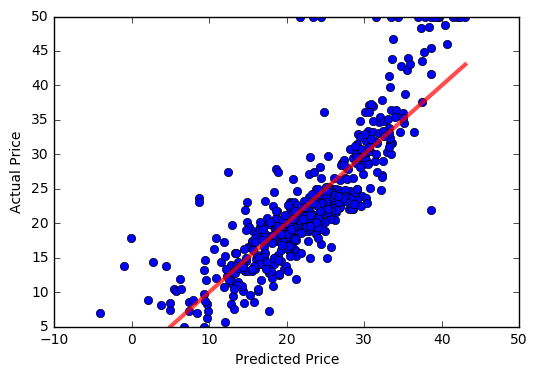

In [31]:
plt.plot(predict,T,'o')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
# add a 45 degree line
a = max(min(predict),min(T))
b = min(max(predict),max(T))
plt.plot([a,b],[a,b], 'r', linewidth=3,alpha=0.7);

In [32]:
new_avgresults = get_avgresults(X2, T, 5, range(0,10))
new_avgresults

array([[ 0.    ,  4.5319,  6.8685,  6.8685],
       [ 1.    ,  4.5322,  6.8389,  6.8389],
       [ 2.    ,  4.5331,  6.8117,  6.8117],
       [ 3.    ,  4.5344,  6.7863,  6.7863],
       [ 4.    ,  4.5361,  6.7626,  6.7626],
       [ 5.    ,  4.5381,  6.7402,  6.7402],
       [ 6.    ,  4.5402,  6.719 ,  6.719 ],
       [ 7.    ,  4.5426,  6.6989,  6.6989],
       [ 8.    ,  4.545 ,  6.6797,  6.6797],
       [ 9.    ,  4.5477,  6.6614,  6.6614]])

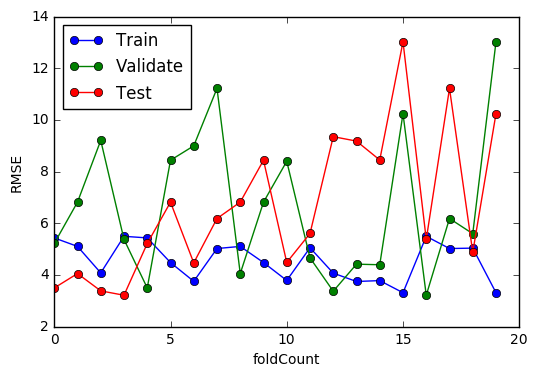

In [33]:
plt.plot(new_results[:,0],new_results[:,2:],'o-')
plt.xlabel('foldCount')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

From this plotting shown above, I found the ranges of the differences of Train errors, Validation errors, and Test errors are getting smaller, which means they are getting stable. In addition, their peak values also getting smaller, which means I reduce the errors. This is absolutely a good change to the linear processing.

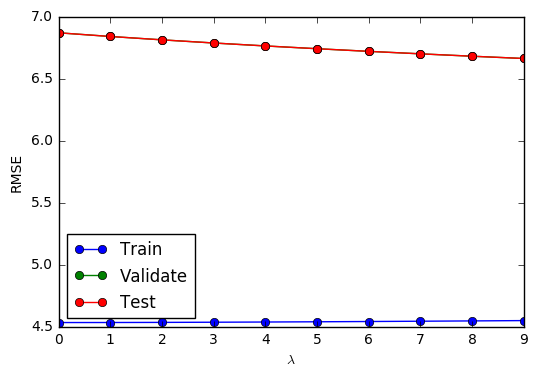

In [34]:
plt.plot(new_avgresults[:,0],new_avgresults[:,1:],'o-')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

Also, from the plotting of the three average errors, the peak values of test errors and validation errors are smaller, which means errors are reduced.

<font color="red">The results after removing the least relevant inputs shows the improvement of reducing errors and optimization of linear processing.</font>

## Grading

In [35]:
%run -i "A2grader.py"

 Testing:
X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X
for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,5,shuffle=False,nPartitions=3)
20/20 points. partitionKFolds produced 20 partitions. Correct.
10/10 points. Final training set contains 12 samples. Correct.
10/10 points. Final validation set contains 4 samples. Correct.
Testing:
X = np.linspace(0,100,1000).reshape((-1,1))
T = X * 0.1
results = multipleLambdas(X,T,4,range(0,10))
20/20 points. All best lambdas are 0.  Correct.
20/20 points. Mean of all train, validation and test errors for best lambda are correct.

Downloads Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.
